In [31]:
import pandas
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import warnings, os, tensorflow as tf

#env parameters
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

In [32]:
num_segments = 19
test_split = 0.3

In [33]:
data = pandas.read_csv('/home/carsten/workspaces/isws/models/predictions_cnn.csv')
num_test_songs = int(len(data)*test_split)

In [34]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

In [35]:
data = data.drop(['offset', 'duration', 'tempo', 'rms', 'blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock'],axis=1)
data.head()

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,reggae.00009.wav,0.421017,1679.434736,2024.534270,3466.256905,0.064117,-262.811999,126.180913,11.227370,21.112270,...,-7.607884,9.588800,-6.119003,3.432182,-3.201820,5.127310,-5.069380,2.687792,1.010708,1.363687
1,reggae.00009.wav,0.398483,1875.148780,2227.413557,4031.587601,0.069351,-220.923940,117.441621,4.900961,20.067881,...,-9.459568,11.513007,-3.310631,5.329873,-4.327653,5.566599,-11.337382,3.472775,-2.983636,-0.154111
2,reggae.00009.wav,0.339041,1833.160181,2189.649126,3916.098976,0.067055,-206.509028,117.687803,3.399634,28.708057,...,-12.858065,6.057907,-4.809681,4.935215,-1.390995,4.663574,-9.885031,5.934896,-3.281801,-3.811287
3,reggae.00009.wav,0.344620,1592.273248,2028.807317,3360.189056,0.054104,-232.590603,127.788885,7.052849,31.868343,...,-13.591460,4.414804,-9.697646,4.287556,1.001181,5.695091,-2.546943,5.661095,0.814606,-2.775566
4,reggae.00009.wav,0.378558,1501.627471,1940.269736,3026.676750,0.051956,-243.499728,132.915085,4.320031,20.461475,...,-10.415287,7.210216,-6.188944,4.976785,-0.566316,5.102638,-1.419239,1.561619,1.570058,0.726551


In [36]:
for i in range(len(data.filename)):
    res = data.iat[i,0]
    res = res.split('.')[0]
    data.iat[i,0] = res

In [37]:
genre_list = data.iloc[:, 0]
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)

In [38]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, 1:], dtype = float))

In [39]:
X_test = X[:num_test_songs]
X_train = X[num_test_songs:]
y_test = y[:num_test_songs]
y_train = y[num_test_songs:]

In [40]:
from keras import models
from keras import layers

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [41]:
val_split = int(19000*0.2)
x_val = X_train[:val_split]
partial_x_train = X_train[val_split:]

y_val = y_train[:val_split]
partial_y_train = y_train[val_split:]
x_norm = preprocessing.scale(x_val)

In [42]:
model = models.Sequential()
#model.add(layers.Dense(512, activation='relu', ))

model.add(layers.Dense(35, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=10),
                 ModelCheckpoint(filepath='./../../../models/ann-model-best.h5', monitor='val_loss', save_best_only=True)]

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=200,
          batch_size=512,
          callbacks=callbacks,
          validation_data=(x_val, y_val))
results = model.evaluate(X_test, y_test)

Train on 9500 samples, validate on 3800 samples
Epoch 1/200
9500/9500 [==============================] - 0s 46us/step - loss: 2.2640 - acc: 0.1312 - val_loss: 2.2279 - val_acc: 0.1839
Epoch 2/200
9500/9500 [==============================] - 0s 8us/step - loss: 2.1317 - acc: 0.2773 - val_loss: 2.1241 - val_acc: 0.2858
Epoch 3/200
9500/9500 [==============================] - 0s 9us/step - loss: 1.9931 - acc: 0.3434 - val_loss: 2.0082 - val_acc: 0.3258
Epoch 4/200
9500/9500 [==============================] - 0s 11us/step - loss: 1.8571 - acc: 0.3717 - val_loss: 1.8691 - val_acc: 0.3516
Epoch 5/200
9500/9500 [==============================] - 0s 8us/step - loss: 1.7279 - acc: 0.4023 - val_loss: 1.7630 - val_acc: 0.3737
Epoch 6/200
9500/9500 [==============================] - 0s 10us/step - loss: 1.6193 - acc: 0.4281 - val_loss: 1.6732 - val_acc: 0.3989
Epoch 7/200
9500/9500 [==============================] - 0s 9us/step - loss: 1.5296 - acc: 0.4555 - val_loss: 1.6091 - val_acc: 0.4242
Epoc

In [43]:
print("Results: " + str(results))

Results: [1.2451479775889924, 0.5942105263157895]


In [44]:
p = model.predict(X_test)

In [45]:
from sklearn.metrics import confusion_matrix
print(p.argmax(axis=1))
r = []
for int_res in p.argmax(axis=1):
    r.append(genres[int_res])
cm = confusion_matrix(encoder.inverse_transform(y_test), r, genres)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.around(cm, decimals=2)

[8 8 8 ... 5 5 5]


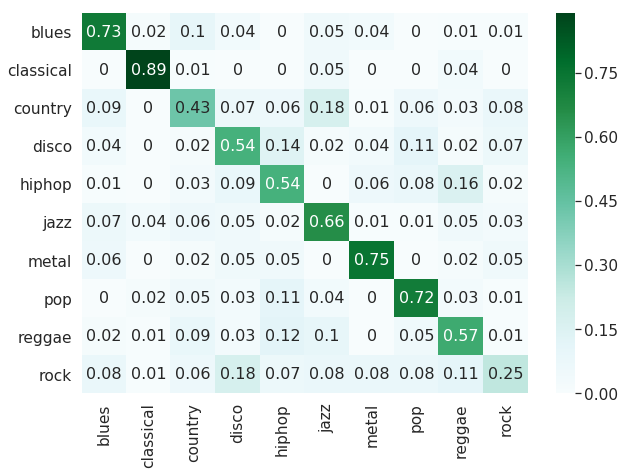

In [46]:
import pandas as pd, seaborn as sn, matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, genres,
                  genres)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size

ax=sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap="BuGn")# font size

In [47]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


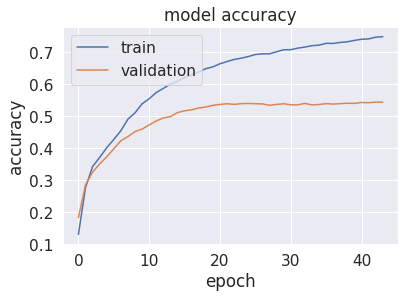

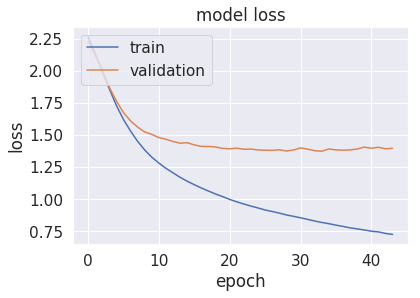

In [48]:
show_summary_stats(history)